### A Gaussian integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate!)
- How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx \approx \frac{1}{N}\sqrt{\frac{\pi}{2}}\sigma\sum_{i=1}^N x_i^3 .$$

with $x_i$ drawn from $p(x) = \frac{2}{\sigma\sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma^2}\right)$

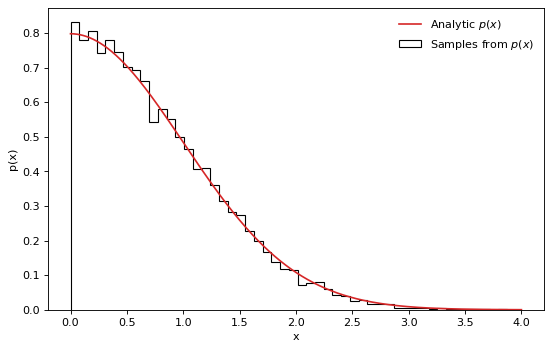

In [2]:
N = 10000
sigma = 1
gauss = scipy.stats.norm(loc=0,scale=sigma)
x = np.linspace(0, 4*sigma, 1000)

#plot
plt.figure(figsize=(8,5), dpi=80) 
plt.hist(abs(gauss.rvs(N)), histtype='step', color='black', density=True, bins=50, label='Samples from $p(x)$');
plt.plot(x, 2*gauss.pdf(x), c = 'tab:red', label = 'Analytic $p(x)$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(frameon=False)

In [3]:
#number of samples 
N = np.logspace(0, 7, 100, dtype=int)
#integral
I = np.array([np.sqrt(np.pi/2)*sigma*np.mean(abs(gauss.rvs(int(n)))**3) for n in N])

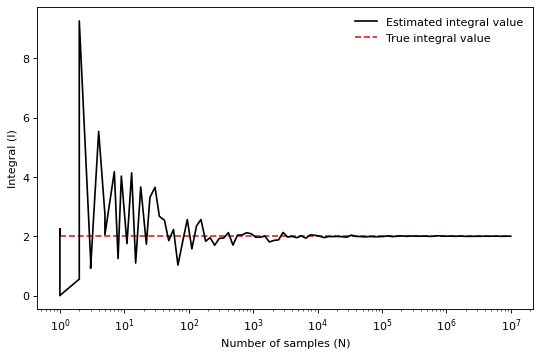

In [4]:
#value of the integral depending on the sample size
plt.figure(figsize=(8,5), dpi=80) 
plt.plot(N, I, c = 'k', label='Estimated integral value')
plt.xscale('log')
plt.hlines(xmin=1, xmax=1e7, y=2*sigma**4, color='tab:red', linestyle='--', label = 'True integral value')
plt.xlabel('Number of samples (N)')
plt.ylabel('Integral (I)')
plt.legend(frameon=False)

The integral converge with the increasing number of samples. I expect the error to go down as $1/\sqrt{N}$ as the error on the mean

Best fit slope = -0.498 +/- 0.0231
Sigmas from expected (-1/2) = 0.0938


Text(0, 0.5, '$|I-2\\sigma^4|$/$2\\sigma^4$')

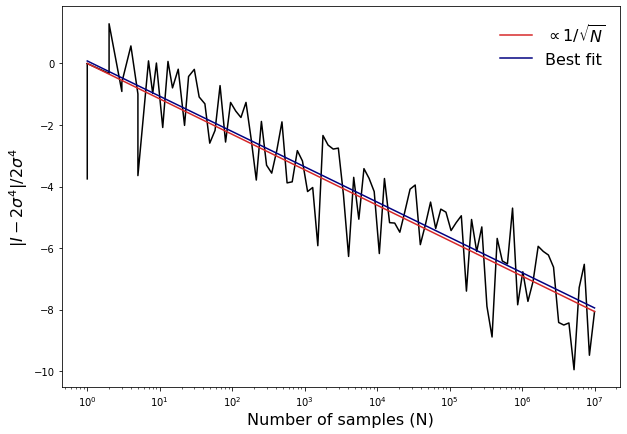

In [16]:
result = np.full(len(I), 2*sigma**4)
error = abs(I-result)/result

def power_law(x, a, b):
    return a*x + b

popt, pcov = curve_fit(power_law, np.log(N), np.log(error), p0 = [-1/2, 1]) #fit
print(f'Best fit slope = {popt[0]:.3} +/- {np.sqrt(pcov[0, 0]):.3}')
print(f'Sigmas from expected (-1/2) = {(popt[0] + 1/2)/np.sqrt(pcov[0, 0]):.3}')

plt.figure(figsize = (10, 7))
plt.plot(N, np.log(error), c = 'k')
plt.plot(N, np.log(N**(-1/2)), c='tab:red', label = '$\propto 1/\sqrt{N}$')
plt.plot(N, power_law(np.log(N), popt[0], popt[1]), color = 'navy', label = 'Best fit')
plt.xscale('log')
plt.legend(frameon=False, fontsize=16)
plt.xlabel('Number of samples (N)', fontsize=16)
plt.ylabel('$|I-2\sigma^4|$/$2\sigma^4$', fontsize=16)

In [37]:
I = []
N_test = [1e1, 1e3, 1e5]
for n_test in N_test:
    I.append(np.array([np.sqrt(np.pi/2)*sigma*np.mean(abs(gauss.rvs(int(n_test)))**3) for n in range(1000)]))

I expect the distribution at small N to be something dependent on the function $f(x)$, while for $N -> +\infty$ it should well approximate a Gaussian distribution

p-value of the KS test with a Normal distribution: 4.7665198541849736e-158
p-value of the KS test with a Normal distribution: 0.259472703226533
p-value of the KS test with a Normal distribution: 0.7395268431120509


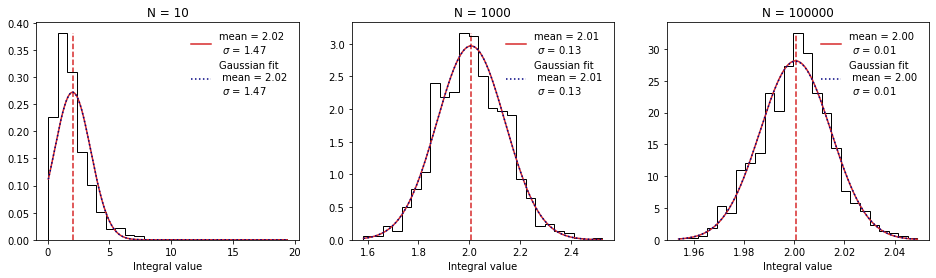

In [51]:
figure, ax = plt.subplots(1, 3, figsize = (16, 4))
for i, axs in enumerate(ax):
    a = axs.hist(I[i], histtype='step', color='black', density=True, bins=25);
    axs.vlines(x = np.mean(I[i]), ymin = 0, ymax = np.max(a[0]), color = 'tab:red', linestyle = '--')
    axs.set_title(f'N = {N_test[i]:.0f}')
    x = np.linspace(np.min(a[1]), np.max(a[1]), 1000)
    axs.plot(x, scipy.stats.norm(loc = np.mean(I[i]), scale = np.std(I[i])).pdf(x), c = 'tab:red', label = 'mean = {:1.2f} \n $\sigma$ = {:1.2f}'.format(np.mean(I[i]), np.std(I[i])))
    axs.set_xlabel('Integral value')
    
    gm = GaussianMixture(n_components=1, n_init=10).fit(I[i][:, np.newaxis])
    x = np.linspace(np.min(I[i]), np.max(I[i]), 1000)
    weights = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(gm.score_samples(x.reshape(-1, 1)))
    axs.plot(x, pdf, color='navy', linestyle=':', label = f'Gaussian fit \n mean = {gm.means_[0, 0]:.2f} \n $\sigma$ = {np.sqrt(gm.covariances_[0, 0, 0]):.2f}')
    
    axs.legend(frameon=False)

    print('p-value of the KS test with a Normal distribution:', scipy.stats.normaltest(I[i])[1])

### 2. Kicking horses

A famous early  application of low-number statistics was an analysis of Prussian cavalryman horse-kick deaths by [Bortkiewicz](https://www.wikiwand.com/en/Ladislaus_Bortkiewicz) in 1898.

He studied the distribution of 122 men kicked to death by horses among 10 Prussian army corps within 20 years (so a total number of corpes of 200). He recorded the number of corps with a given number of deaths:

| Number of deaths | Number of groups |
| --- | --- |
| 0 | 109 |
| 1 | 65 |
| 2 | 22 |
| 3 | 3 |
| 4 | 1 |

- Plot the resulting probability distribution. Careful with the normalization
- How does it look like? Again try to fit it by hand.

(Hint: think about sample mean and sample variance)


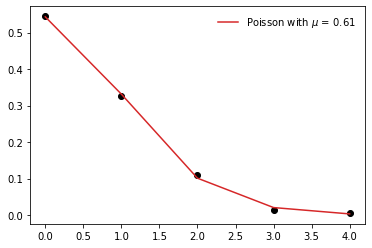

In [27]:
deaths = np.array([0, 1, 2, 3, 4])
groups = np.array([109, 65, 22, 3, 1])

freq = groups/np.sum(groups)
plt.scatter(deaths, freq, c = 'k')

mu = np.average(deaths, weights = groups)
plt.plot(deaths, scipy.stats.poisson(mu).pmf(deaths), c = 'tab:red', label = 'Poisson with $\mu$ = {:1.2f}'.format(mu))
plt.legend(frameon=False)